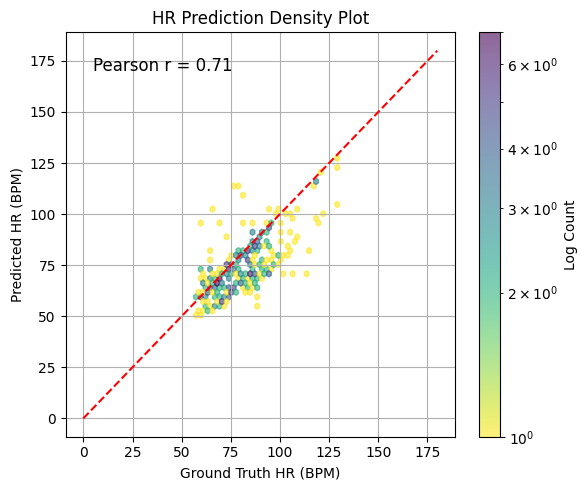

[INFO] Total number of videos processed: 358


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === 1. Read inference_log.txt ===
log_file_path = "/home/siming/physformer_vipl/Inference_Physformer_VIPL/inference_log.txt"
with open(log_file_path, "r") as f:
    log_text = f.read()

# === 2. Extract video / HR / GT ===
pattern = r"Processing (p\d+-v\d+-source\d+).avi.*?HR: ([\d.]+) \| GT: ([\d.]+)"
matches = re.findall(pattern, log_text, re.DOTALL)
df = pd.DataFrame(matches, columns=["file_name", "pred_HR", "gt_HR"])
df["pred_HR"] = df["pred_HR"].astype(float)
df["gt_HR"] = df["gt_HR"].astype(float)

# # === 3. Filter out values with GT < 25 ===
# df = df[df['gt_HR'] >= 25].reset_index(drop=True)

# === 4. Plot Hexbin density ===
plt.figure(figsize=(6, 5))
plt.hexbin(df['gt_HR'], df['pred_HR'], gridsize=30, cmap='viridis_r', bins='log', alpha=0.6)
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')
plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot")
plt.colorbar(label="Log Count")

# === 5. Pearson correlation coefficient ===
r, _ = pearsonr(df['gt_HR'], df['pred_HR'])
plt.text(5, 170, f'Pearson r = {r:.2f}', fontsize=12, color='black')

plt.grid(True)
plt.tight_layout()
plt.show()

print(f"[INFO] Total number of videos processed: {len(df)}")


[INFO] MAE: 8.99 BPM


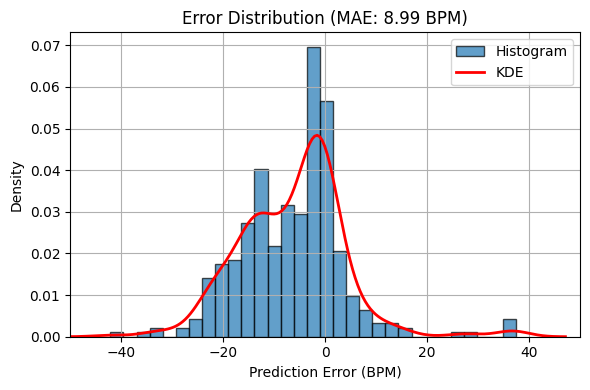

In [2]:
import numpy as np
import seaborn as sns

errors = df['pred_HR'] - df['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
plt.xlim(-50,50)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


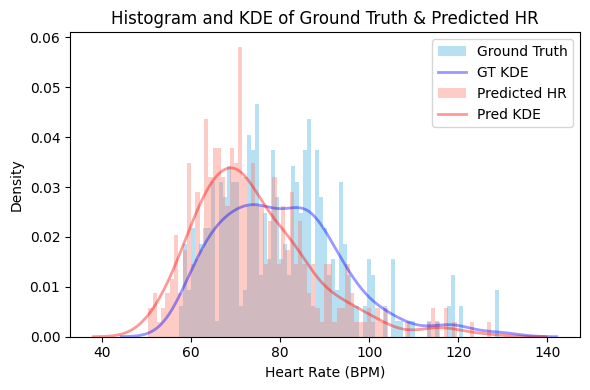

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
# Ground Truth
plt.hist(df['gt_HR'], bins=80, alpha=0.6, label='Ground Truth', color='skyblue', density=True)
sns.kdeplot(df['gt_HR'], color='blue', linewidth=2, label='GT KDE', alpha=0.4)
# Predicted HR
plt.hist(df['pred_HR'], bins=80, alpha=0.4, label='Predicted HR', color='salmon', density=True)
sns.kdeplot(df['pred_HR'], color='red', linewidth=2, label='Pred KDE', alpha=0.4)

plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Density')
plt.title('Histogram and KDE of Ground Truth & Predicted HR')
plt.legend()
plt.tight_layout()
plt.show()

[INFO] MAE: 0.00 BPM


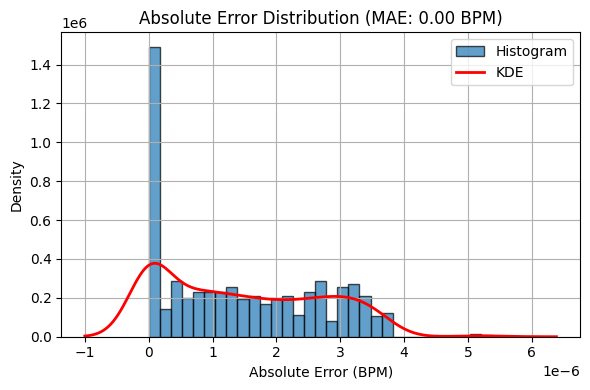

In [13]:
import numpy as np
import seaborn as sns

abs_errors = np.abs(df['pred_HR'] - df['gt_HR'])
mae = abs_errors.mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(abs_errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(abs_errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Absolute Error (BPM)')
plt.ylabel('Density')
plt.title(f'Absolute Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import pearsonr

gt = np.array(df['gt_HR'])    # Ground truth HR
pred = np.array(df['pred_HR'])  # Predicted HR

# MAE (Mean Absolute Error)
mae = np.mean(np.abs(gt - pred))

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((gt - pred) ** 2))

# Pearson Correlation
r, _ = pearsonr(gt, pred)

# Bias (Mean Error)
bias = np.mean(pred - gt)

# Print results
print(f"MAE: {mae:.2f} BPM")
print(f"RMSE: {rmse:.2f} BPM")
print(f"Bias: {bias:.2f} BPM")
print(f"Pearson r: {r:.2f}")


MAE: 0.00 BPM
RMSE: 0.00 BPM
Bias: -0.00 BPM
Pearson r: 1.00


Text(0, 0.5, 'Prediction Error (BPM)')

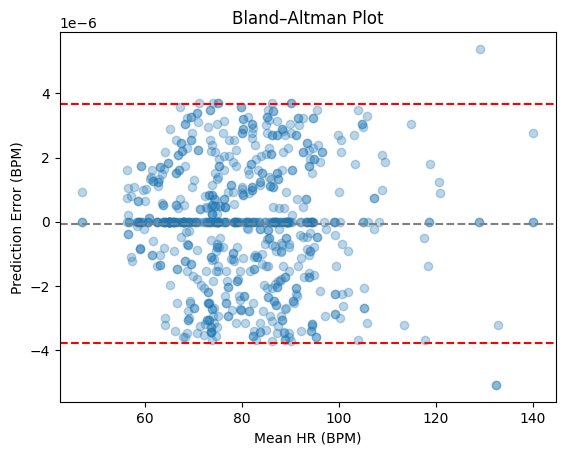

In [16]:
import matplotlib.pyplot as plt

mean = (gt + pred) / 2
diff = pred - gt
md = np.mean(diff)
sd = np.std(diff)

plt.scatter(mean, diff, alpha=0.3)
plt.axhline(md, color='gray', linestyle='--')
plt.axhline(md + 1.96*sd, color='red', linestyle='--')
plt.axhline(md - 1.96*sd, color='red', linestyle='--')
plt.title("Bland–Altman Plot")
plt.xlabel("Mean HR (BPM)")
plt.ylabel("Prediction Error (BPM)")


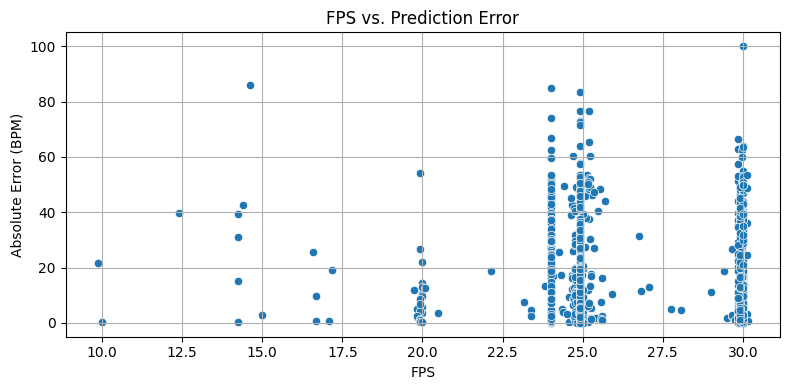

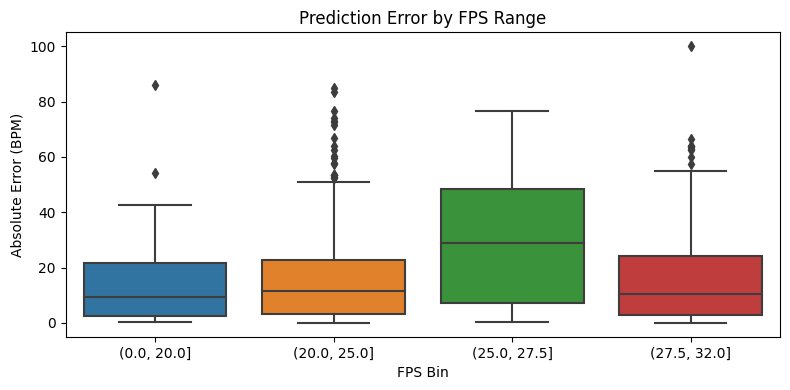

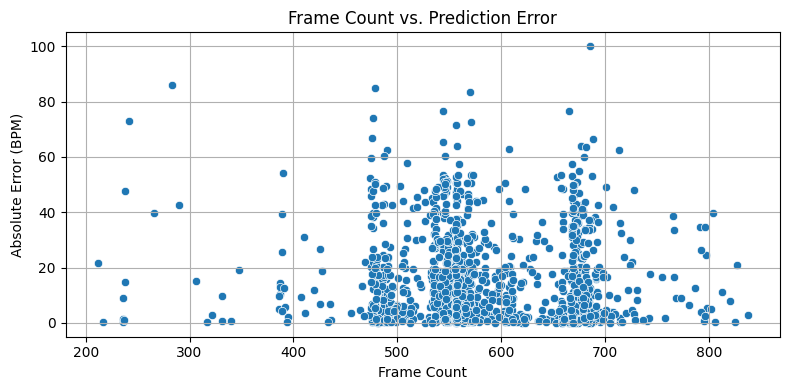

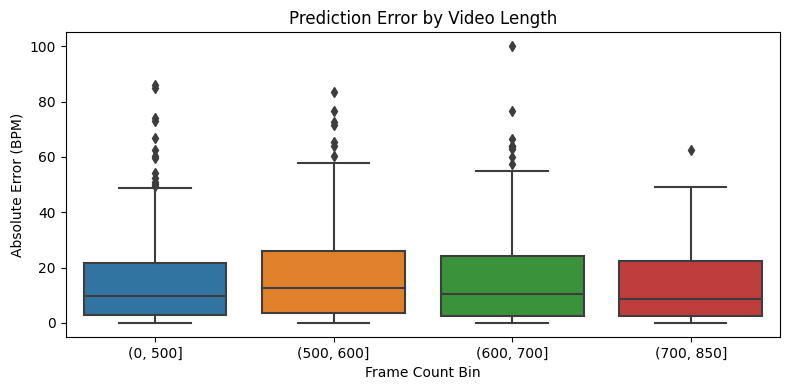

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add .mp4 suffix (only once)
sample_info["file_name"] = sample_info["file_name"].astype(str).str.strip()
sample_info["file_name"] = sample_info["file_name"].apply(lambda x: x if x.endswith(".mp4") else x + ".mp4")

# Clean df
df["file_name"] = df["file_name"].astype(str).str.strip()

# Merge
df_merged = df.merge(
    sample_info[["file_name", "fps", "frame_cnt"]],
    on="file_name",
    how="left"
)

# Add error column
df_merged["abs_error"] = abs(df_merged["pred_HR"] - df_merged["gt_HR"])

# Assume df contains fps, frame_cnt, gt_HR, pred_HR
df_merged["abs_error"] = abs(df_merged["gt_HR"] - df_merged["pred_HR"])

# -------- FPS vs Error --------
plt.figure(figsize=(8, 4))
sns.scatterplot(x="fps", y="abs_error", data=df_merged)
plt.xlabel("FPS")
plt.ylabel("Absolute Error (BPM)")
plt.title("FPS vs. Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: FPS binning
df_merged["fps_bin"] = pd.cut(df_merged["fps"], bins=[0, 20, 25, 27.5, 32], right=True)
plt.figure(figsize=(8, 4))
sns.boxplot(x="fps_bin", y="abs_error", data=df_merged)
plt.xlabel("FPS Bin")
plt.ylabel("Absolute Error (BPM)")
plt.title("Prediction Error by FPS Range")
plt.tight_layout()
plt.show()


# -------- Frame Count vs Error --------
plt.figure(figsize=(8, 4))
sns.scatterplot(x="frame_cnt", y="abs_error", data=df_merged)
plt.xlabel("Frame Count")
plt.ylabel("Absolute Error (BPM)")
plt.title("Frame Count vs. Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Frame count binning
df_merged["frame_bin"] = pd.cut(df_merged["frame_cnt"], bins=[0, 500, 600, 700, 850], right=True)
plt.figure(figsize=(8, 4))
sns.boxplot(x="frame_bin", y="abs_error", data=df_merged)
plt.xlabel("Frame Count Bin")
plt.ylabel("Absolute Error (BPM)")
plt.title("Prediction Error by Video Length")
plt.tight_layout()
plt.show()


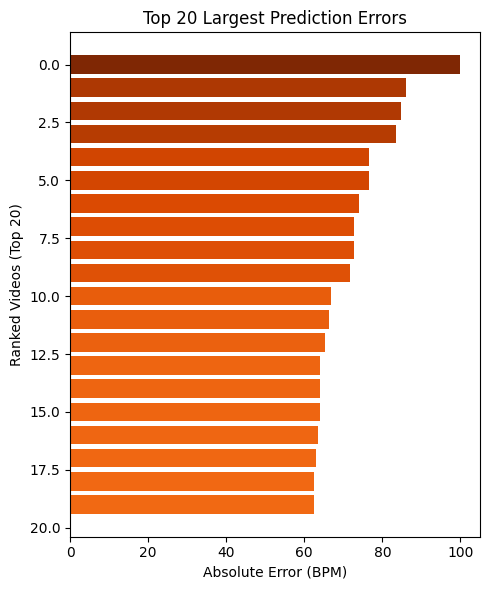

In [ ]:
import numpy as np
import pandas as pd

# Example data
gt = np.array(df['gt_HR'])           # Ground Truth HR
pred = np.array(df['pred_HR'])       # Predicted HR
video_ids = np.array(df['file_name'])  # Corresponding video ID or path name

# Compute absolute errors
errors = np.abs(pred - gt)

# Sort and find Top-N largest errors
N = 20  # gt.size #500
top_idx = np.argsort(errors)[-N:][::-1]  # Descending order, largest first

# Extract information
top_df = pd.DataFrame({
    'Video ID': video_ids[top_idx],
    'Ground Truth HR': gt[top_idx],
    'Predicted HR': pred[top_idx],
    'Absolute Error': errors[top_idx]
})

# Output to CSV
top_df.to_csv('/home/siming/physformer/Physformer_Run/top_'+str(N)+'_errors.csv', index=False)

import matplotlib.pyplot as plt
import numpy as np

# Assume you already have top_df dataframe
top_n = N
errors = top_df["Absolute Error"].values
video_ids = top_df["Video ID"].values

plt.figure(figsize=(5,6))  # Increase height for clarity
bars = plt.barh(range(top_n), errors, color=plt.cm.Oranges(errors / errors.max()))

# Add ranks on the left (e.g., 1, 2, ..., N)
# plt.yticks(ticks=np.arange(top_n), labels=[f"{i+1}" for i in range(top_n)], fontsize=7)
plt.xlabel("Absolute Error (BPM)")
plt.ylabel("Ranked Videos (Top "+str(top_n)+")")
plt.title("Top "+str(top_n)+" Largest Prediction Errors")

plt.gca().invert_yaxis()  # Largest error on top
plt.tight_layout()
plt.show()


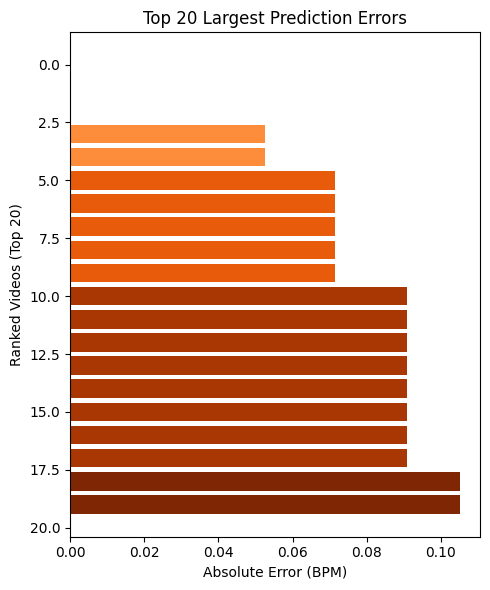

In [ ]:
import numpy as np
import pandas as pd

# Example data
gt = np.array(df['gt_HR'])           # Ground Truth HR
pred = np.array(df['pred_HR'])       # Predicted HR
video_ids = np.array(df['file_name'])  # Corresponding video ID or path name

# Compute absolute errors
errors = np.abs(pred - gt)

# Sort and find Top-N smallest errors
N = 20  # gt.size #500
bottom_idx = np.argsort(errors)[:N]  # Ascending order, smallest first

# Extract information
top_df = pd.DataFrame({
    'Video ID': video_ids[bottom_idx],
    'Ground Truth HR': gt[bottom_idx],
    'Predicted HR': pred[bottom_idx],
    'Absolute Error': errors[bottom_idx]
})

# Save to CSV
top_df.to_csv('/home/siming/physformer/Physformer_Run/bottom_'+str(N)+'_errors.csv', index=False)

import matplotlib.pyplot as plt
import numpy as np

# Assume you already have top_df dataframe
top_n = N
errors = top_df["Absolute Error"].values
video_ids = top_df["Video ID"].values

plt.figure(figsize=(5,6))  # Increase height for clarity
bars = plt.barh(range(top_n), errors, color=plt.cm.Oranges(errors / errors.max()))

# Add ranks on the left (e.g., 1, 2, ..., N)
# plt.yticks(ticks=np.arange(top_n), labels=[f"{i+1}" for i in range(top_n)], fontsize=7)
plt.xlabel("Absolute Error (BPM)")
plt.ylabel("Ranked Videos (Top "+str(top_n)+")")
plt.title("Top "+str(top_n)+" Smallest Prediction Errors")

plt.gca().invert_yaxis()  # Best predictions (smallest errors) on top
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Assume gt and pred are numpy arrays
gt = np.array(df['gt_HR'])
pred = np.array(df['pred_HR'])

# Ground Truth distribution
gt_unique, gt_counts = np.unique(gt, return_counts=True)
gt_df = pd.DataFrame({'HR': gt_unique, 'Count': gt_counts}).sort_values(by='Count', ascending=False)

# Prediction distribution
pred_unique, pred_counts = np.unique(pred, return_counts=True)
pred_df = pd.DataFrame({'HR': pred_unique, 'Count': pred_counts}).sort_values(by='Count', ascending=False)

# Output top 10 most frequent HR values
print("🎯 Ground Truth - Top 10 Most Frequent HR:")
print(gt_df.head(10))

print("\n🎯 Predicted HR - Top 10 Most Frequent HR:")
print(pred_df.head(10))


🎯 Ground Truth - Top 10 Most Frequent HR:
      HR  Count
23  70.0     67
21  68.0     60
18  65.0     55
22  69.0     47
25  72.0     44
26  73.0     43
20  67.0     42
29  76.0     39
33  80.0     38
36  83.0     38

🎯 Predicted HR - Top 10 Most Frequent HR:
           HR  Count
57  90.000000     82
45  79.090909     67
52  84.545455     65
42  76.363636     63
49  81.818182     63
7   35.454545     50
35  70.909091     45
38  73.636364     44
31  68.181818     40
39  73.928571     37


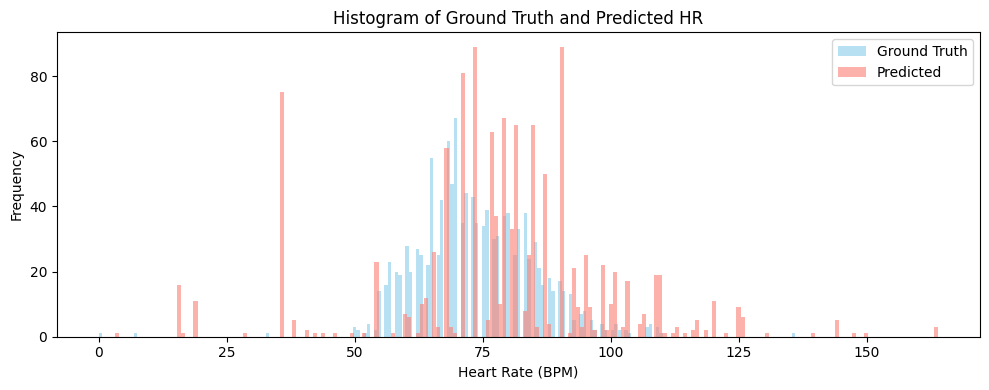

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(gt, bins=200, alpha=0.6, label='Ground Truth', color='skyblue')
plt.hist(pred, bins=200, alpha=0.6, label='Predicted', color='salmon')
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Frequency')
plt.title('Histogram of Ground Truth and Predicted HR')
plt.legend()
plt.tight_layout()
plt.show()


                                           file_name    pred_HR  gt_HR
0  959-20230426212426785_tmp_9ccc62b1c0a18b14c809...  70.714286   73.0
1  960-20230429085552277_tmp_2a736f45b9eebe4bb981...  80.357143   70.0
2  961-20230430105934489_tmp_4c82a31346fa76a44676...  61.071429   72.0
3  962-20230503154237807_tmp_33d1a2a4f5af8f20dccd...  77.142857   80.0
4  963-20230506065854701_tmp_a61b26ec2446c9718217...  70.714286   81.0
[INFO] Columns: ['file_name', 'pred_HR', 'gt_HR']


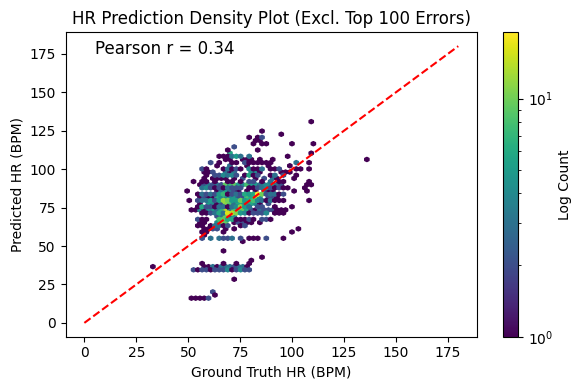

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === 1. Read CSV ===
df = pd.read_csv('/home/siming/physformer/Physformer_Run_7.17/HR_results.csv')
sample_info = pd.read_csv('/home/siming/physformer/sample_info.csv')

print(df.head())
print("[INFO] Columns:", df.columns.tolist())

# === 2. Compute absolute error and remove Top 100 largest error samples ===
df['abs_error'] = (df['gt_HR'] - df['pred_HR']).abs()
df_filtered = df.sort_values('abs_error', ascending=False).iloc[100:]  # Drop top 100 largest errors

# === 3. Plot hexbin scatter density ===
plt.figure(figsize=(6, 4))
plt.hexbin(df_filtered['gt_HR'], df_filtered['pred_HR'], gridsize=50, cmap='viridis', bins='log')
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # Ideal line

plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot (Excl. Top 100 Errors)")
plt.colorbar(label="Log Count")

# === 4. Add Pearson correlation coefficient ===
r, _ = pearsonr(df_filtered['gt_HR'], df_filtered['pred_HR'])
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')

plt.tight_layout()
plt.show()


[INFO] MAE: 12.94 BPM


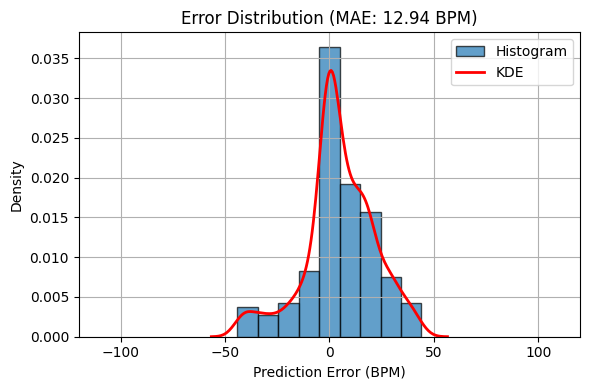

In [50]:
import numpy as np
import seaborn as sns

errors = df_filtered['pred_HR'] - df_filtered['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=9, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
plt.xlim(-120, 120)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import re
import pandas as pd

def extract_hr_data(log_text):
    pattern = re.compile(
        r"\[INFO\] Finished ([\w\-.]+\.mp4).+?: Pred HR = ([\d.]+) \| GT HR = ([\d.]+)"
    )
    matches = pattern.findall(log_text)
    df = pd.DataFrame(matches, columns=["video_name", "pred_HR", "gt_HR"])
    df["pred_HR"] = df["pred_HR"].astype(float)
    df["gt_HR"] = df["gt_HR"].astype(float)
    return df

# Read old version (fewer videos)
with open("/home/siming/physformer/Physformer_Run/inference_log.txt", "r") as f:
    log_old = f.read()
df_old = extract_hr_data(log_old)
df_old = df_old.rename(columns={"pred_HR": "old_pred_HR", "gt_HR": "gt_HR"})

# Read new version (Physformer_Run_7.17)
with open("/home/siming/physformer/Physformer_Run_7.17/inference_log.txt", "r") as f:
    log_new = f.read()
df_new = extract_hr_data(log_new)
df_new = df_new.rename(columns={"pred_HR": "new_pred_HR", "gt_HR": "gt_HR_new"})

# Merge two versions (based on old version videos)
df_merged = pd.merge(df_old, df_new, on="video_name", how="left")

# Check if GT is consistent
gt_diff = (df_merged["gt_HR"] - df_merged["gt_HR_new"]).abs()
if gt_diff.max() > 1e-2:
    print("⚠️ Warning: GT HR mismatch between versions!")
df_merged = df_merged.drop(columns=["gt_HR_new"])

print("df_merged rows:", len(df_merged))


df_merged 行数: 159


[INFO] MAE: 14.51 BPM


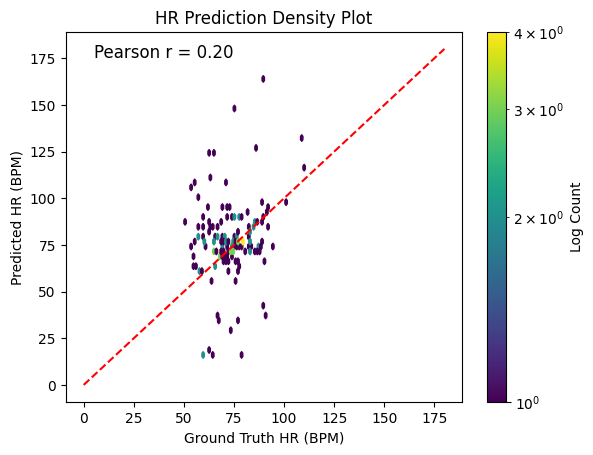

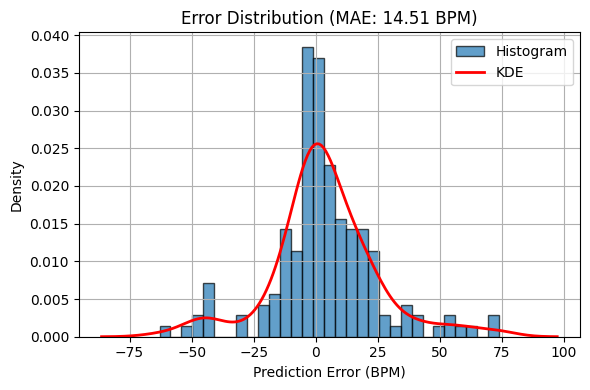

In [ ]:
plt.hexbin(df_merged['gt_HR'], df_merged['new_pred_HR'], gridsize=50, cmap='viridis', bins='log')
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # Ideal line
plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot")
plt.colorbar(label="Log Count")

from scipy.stats import pearsonr
r, _ = pearsonr(df_merged['gt_HR'], df_merged['new_pred_HR'])
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')


import numpy as np
import seaborn as sns

errors = df_merged['new_pred_HR'] - df_merged['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
# plt.xlim(-50, 50)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[INFO] MAE: 14.46 BPM


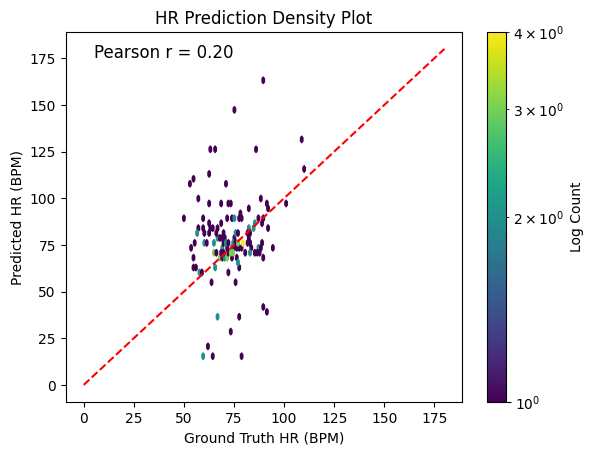

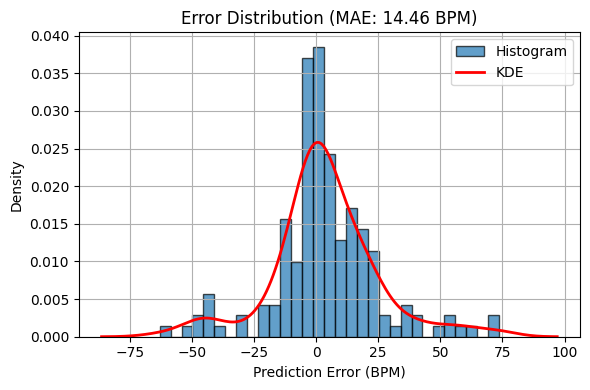

In [ ]:
plt.hexbin(df_merged['gt_HR'], df_merged['old_pred_HR'], gridsize=50, cmap='viridis', bins='log')
plt.plot([0, 180], [0, 180], 'r--', label='Ideal line')  # Ideal line
plt.xlabel("Ground Truth HR (BPM)")
plt.ylabel("Predicted HR (BPM)")
plt.title("HR Prediction Density Plot")
plt.colorbar(label="Log Count")

from scipy.stats import pearsonr
r, _ = pearsonr(df_merged['gt_HR'], df_merged['old_pred_HR'])
plt.text(5, 175, f'Pearson r = {r:.2f}', fontsize=12, color='black')


import numpy as np
import seaborn as sns

errors = df_merged['old_pred_HR'] - df_merged['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
# Plot histogram
plt.hist(errors, bins=31, alpha=0.7, edgecolor='k', density=True, label='Histogram')
# Plot KDE curve
sns.kdeplot(errors, color='red', linewidth=2, label='KDE')

plt.xlabel('Prediction Error (BPM)')
# plt.xlim(-50, 50)
plt.ylabel('Density')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


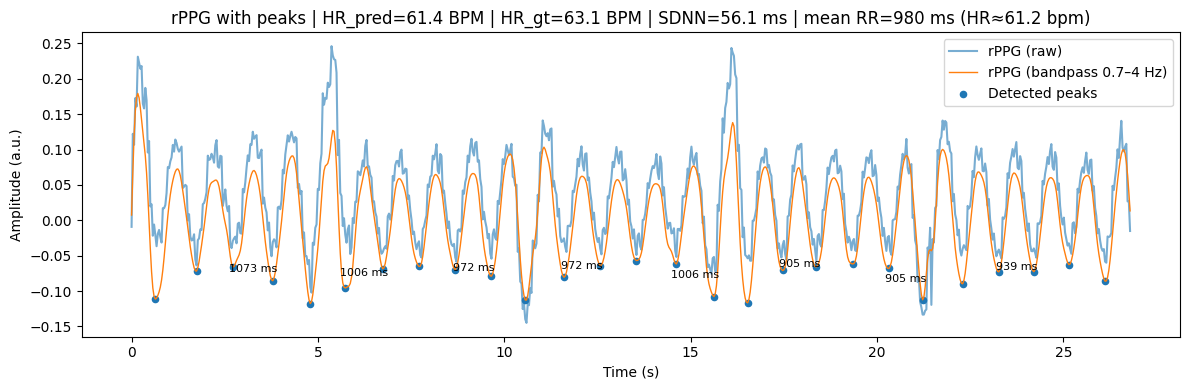

In [51]:
import numpy as np
import scipy.io as sio
import scipy.signal as sg
import matplotlib.pyplot as plt
import pandas as pd

# Load .mat file
mat_path = "/home/siming/physformer_vipl/Inference_Physformer_VIPL_rrhrv/outputs_rPPG_rr_sdnn.mat"
mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)

# -------- helpers: unpack object/struct, extract first rPPG and fps --------
def extract_first_signal_and_fps(cell):
    x, fps = cell, None
    while True:
        if isinstance(x, np.ndarray):
            if x.dtype == object:
                x = x.ravel()[0]; continue
            return np.asarray(x, float).squeeze(), fps
        if hasattr(x, "_fieldnames"):  # mat_struct
            s = x
            for k in ("fps","Fs","fs"):
                if k in s._fieldnames:
                    try: fps = float(np.asarray(getattr(s,k)).squeeze())
                    except: pass
            for name in ("rppg","rPPG","signal","sig","data","y","x"):
                if name in s._fieldnames:
                    x = getattr(s, name); break
            else:
                raise ValueError(f"Unknown rPPG field, candidates: {s._fieldnames}")
            continue
        if isinstance(x, (list,tuple)):
            try: return np.asarray(x, float).squeeze(), fps
            except: x = x[0]; continue
        return np.asarray(x, float).squeeze(), fps

rppg, fps = extract_first_signal_and_fps(mat["results_rPPG"])
if fps is None or not np.isfinite(fps):  # if not saved, fall back to dataset framerate
    fps = 30.0  # TODO: replace with true fps if known

# -------- Load CSV, extract HR/HR_gt/SDNN --------
csv_path = "/home/siming/physformer_vipl/Inference_Physformer_VIPL_rrhrv/all_metrics_with_rr.csv"
df_metrics = pd.read_csv(csv_path)

# Assume the first row corresponds to this signal (adjust index/filename matching if needed)
row = df_metrics.iloc[0]
hr_pred = row['HR_pred']
hr_gt = row['gt_HR'] if 'gt_HR' in row else (row['HR_gt'] if 'HR_gt' in row else None)
sdnn_ms = row['SDNN_ms'] if 'SDNN_ms' in row else (row['sdnn'] if 'sdnn' in row else None)

# -------- bandpass + peak detection (auto decide polarity) --------
low, high = 0.7, 4.0
b, a = sg.butter(3, [low/(fps/2), high/(fps/2)], btype="band")
filt = sg.filtfilt(b, a, sg.detrend(rppg))

def detect(sig):
    min_dist = int(np.floor(fps * 60 / 180.0))
    prom = 0.3 * np.std(sig)
    peaks, _ = sg.find_peaks(sig, distance=max(1, min_dist), prominence=max(1e-6, prom))
    return peaks

peaks_pos = detect(filt)
peaks_neg = detect(-filt)

def rr_ms_from_peaks(peaks):
    if len(peaks) < 2: return None
    return np.diff(peaks) / fps * 1000.0

cand = []
if len(peaks_pos) >= 2: cand.append((peaks_pos, rr_ms_from_peaks(peaks_pos)))
if len(peaks_neg) >= 2: cand.append((peaks_neg, rr_ms_from_peaks(peaks_neg)))
peaks = max(cand, key=lambda x: -np.nanstd(x[1]))[0] if len(cand)==2 else cand[0][0]

rr_ms = rr_ms_from_peaks(peaks)
mask = (rr_ms >= 300) & (rr_ms <= 2000)
rr_ms_clean = rr_ms[mask]
peaks_clean = peaks[np.r_[True, mask]]

# -------- Plot: rPPG + peaks + RR labels + HR/HR_gt/SDNN --------
t = np.arange(len(rppg)) / fps
plt.figure(figsize=(12,4))
plt.plot(t, rppg, label="rPPG (raw)", alpha=0.6)
plt.plot(t, filt, label="rPPG (bandpass 0.7–4 Hz)", linewidth=1)
plt.scatter(t[peaks_clean], filt[peaks_clean], s=20, label="Detected peaks")

# Annotate RR intervals
for i in range(1, len(peaks_clean)):
    if i % 3 == 0:
        rr_val = (peaks_clean[i] - peaks_clean[i-1]) / fps * 1000.0
        xm = 0.5*(t[peaks_clean[i]] + t[peaks_clean[i-1]])
        ym = 0.5*(filt[peaks_clean[i]] + filt[peaks_clean[i-1]])
        plt.text(xm, ym, f"{rr_val:.0f} ms", fontsize=8, ha="center", va="bottom")

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")

# Construct title: HR, HR_gt, SDNN
title = f"rPPG with peaks"
if hr_pred is not None:
    title += f" | HR_pred={hr_pred:.1f} BPM"
if hr_gt is not None and not pd.isnull(hr_gt):
    title += f" | HR_gt={hr_gt:.1f} BPM"
if sdnn_ms is not None and not pd.isnull(sdnn_ms):
    title += f" | SDNN={sdnn_ms:.1f} ms"
title += f" | mean RR={np.mean(rr_ms_clean):.0f} ms (HR≈{60000/np.mean(rr_ms_clean):.1f} bpm)"

plt.title(title)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


           file_name        fps    HR_pred      HR_gt     SDNN_ms  RR_count  \
0  p1-v1-source1.avi  29.824965  61.400000  63.055556   56.053276        27   
1  p1-v1-source2.avi  25.000000  55.428571  64.044444  230.763013        42   
2  p1-v1-source3.avi  29.986174  61.400000  63.055556   49.232978        27   
3  p1-v1-source4.avi  29.986174  40.000000  63.055556  434.536993        22   
4  p1-v2-source1.avi  29.812453  70.833333  68.825000  118.666115        39   

                                                  RR  RespRate_bpm  \
0  [1039.3976833976833, 1005.8687258687257, 1072....     18.015080   
1  [1040.0, 960.0, 1280.0000000000002, 1399.99999...     18.000000   
2  [1033.8097982708935, 967.1123919308355, 1033.8...     18.021740   
3  [1500.6916426512967, 700.3227665706052, 666.97...     12.014494   
4  [637.3175559380379, 670.8605851979346, 603.774...     12.005015   

   RespRate_SNR  
0      6.557411  
1      2.038230  
2      2.379732  
3      2.824927  
4      2.26810

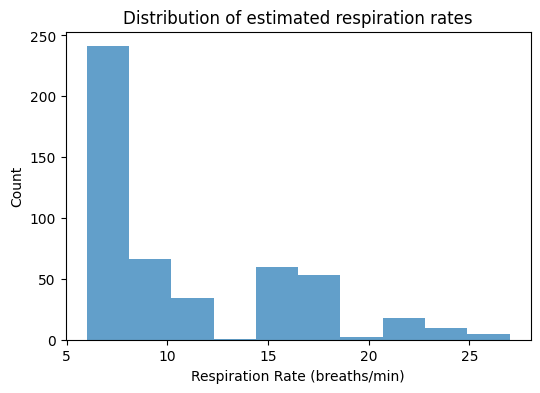

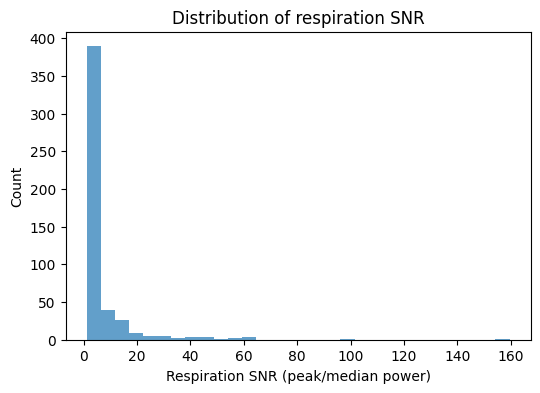

In [27]:
import pandas as pd

csv_path = "/home/siming/physformer_vipl/Inference_Physformer_VIPL_rrhrv/all_metrics_with_rr.csv"
df = pd.read_csv(csv_path)

print(df.head())

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df["RespRate_bpm"].dropna(), bins=10, alpha=0.7)
plt.xlabel("Respiration Rate (breaths/min)")
plt.ylabel("Count")
plt.title("Distribution of estimated respiration rates")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["RespRate_SNR"].dropna(), bins=30, alpha=0.7)
plt.xlabel("Respiration SNR (peak/median power)")
plt.ylabel("Count")
plt.title("Distribution of respiration SNR")
plt.show()


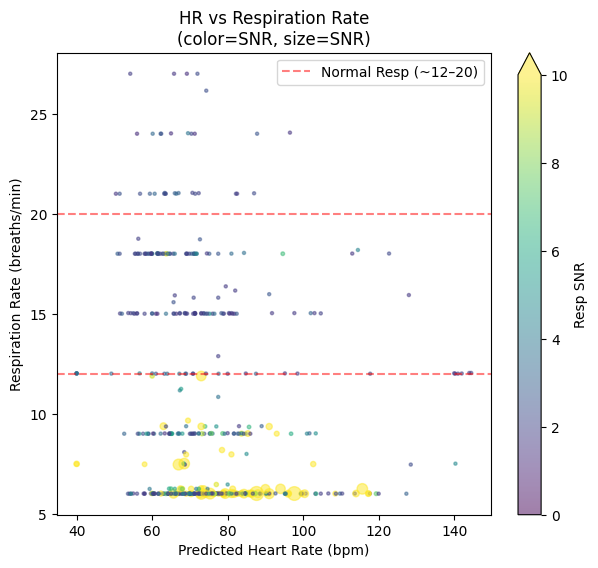

In [ ]:
plt.figure(figsize=(7,6))
sc = plt.scatter(df["HR_pred"], df["RespRate_bpm"], 
                 c=df["RespRate_SNR"], cmap="viridis", 
                 vmin=0, vmax=10,              # Limit color range
                 s=np.clip(df["RespRate_SNR"], 5, 100), alpha=0.5)  # Limit bubble size

# Set colorbar, extend if values exceed 50
cbar = plt.colorbar(sc, label="Resp SNR", extend="max")

plt.xlabel("Predicted Heart Rate (bpm)")
plt.ylabel("Respiration Rate (breaths/min)")
plt.title("HR vs Respiration Rate\n(color=SNR, size=SNR)")
plt.axhline(12, color="r", linestyle="--", alpha=0.5, label="Normal Resp (~12–20)")
plt.axhline(20, color="r", linestyle="--", alpha=0.5)
plt.legend()
plt.show()


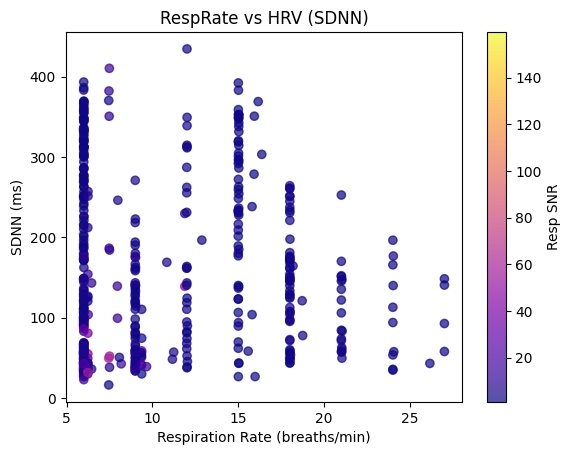

In [32]:
plt.scatter(df["RespRate_bpm"], df["SDNN_ms"], 
            c=df["RespRate_SNR"], cmap="plasma", alpha=0.7)
plt.colorbar(label="Resp SNR")
plt.xlabel("Respiration Rate (breaths/min)")
plt.ylabel("SDNN (ms)")
plt.title("RespRate vs HRV (SDNN)")
plt.show()
